In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm
import copy

In [3]:
emb_dim=50

# Terms

* variable
* function
* predicate
* clause

In [4]:
class Predicate:
    def __init__(self, name, variables, negation):
        self.name=name
        self.variables=variables
        self.negation=negation
    
    def show(self):
        s=''
        if self.negation:
            s+='¬'
        s='%s%s(%s)'%(s,self.name,', '.join(self.variables))
        return s

In [5]:
class Clause:
    def __init__(self, v,w,predicates, weight=1.0):
        self.v=float(v)
        self.w=float(w)
        self.predicates=predicates
        self.weight=weight
    def show(self):
        ss=[]
        for p in self.predicates:
            ss.append(p.show())
        ss=' ∨ '.join(ss)
#         ss='%0.2f: '%(self.weight)+ss
        return ss

In [6]:
class KnowledgeBase:
    def __init__(self,clauses):
        self.clauses=clauses
    def show(self):
        for i,c in enumerate(self.clauses):
            print(c.show())
    def union(self, knowledge_base):
        new_knowledge_base=copy.deepcopy(self)
        for clause in knowledge_base.clauses:
            new_knowledge_base.clauses.append(clause)
        return new_knowledge_base

In [8]:
class Propositional:
    def __init__(self, v, w, conditions, clause):
        self.v = v
        self.w = w
        self.conditions = conditions
        self.clause = clause

    def generate_knowledge_base(self,constants):
        self.knowledge_base = KnowledgeBase([self.clause])
        for condition in self.conditions:
            new_knowledge_base = self.bound_knowledge_base(
                self.knowledge_base, condition[1], constants, condition[0])
            self.knowledge_base = new_knowledge_base
        return self.knowledge_base

    def bound_knowledge_base(self, knowledge_base, variable, constants,
                             existential):
        clauses = []
        for clause in knowledge_base.clauses:
            clauses += self.bound_clause_variable_with_constants(
                clause, variable, constants, existential)
#         for i in range(len(clauses)):
#             clauses[i].weight=1.0/len(clauses)
        return KnowledgeBase(clauses=clauses)

    def bound_clause_variable_with_constants(self, clause, variable, constants,
                                             existential):
        clauses = []
        for constant in constants:
            clauses.append(
                self.bound_clause_variable_with_constant(
                    clause, variable, constant))
        if existential:
            all_predicates = []
            for clause in clauses:
                all_predicates += clause.predicates
            return [Clause(clauses[0].v, clauses[0].w, all_predicates)]
        else:
            return clauses

    def bound_clause_variable_with_constant(self, clause, variable, constant):
        new_clause = copy.deepcopy(clause)
        for i in range(len(clause.predicates)):
            for j in range(len(new_clause.predicates[i].variables)):
                if new_clause.predicates[i].variables[j] == variable:
                    new_clause.predicates[i].variables[j] = constant
        return new_clause

In [9]:
def load_knowledge_base(filename):
    clauses=[]
    for line in open(filename):
        line=line.strip().split('|')
        v,w=line[0].split(',')
        line=line[1].strip().split(',')
        if line[0]=='not':
            negation=True
            line=line[1:]
        else:
            negation=False
        predicate=Predicate(name=line[0],negation=negation,variables=line[1:])
        clauses.append(Clause(v=v,w=w,predicates=[predicate]))
    return KnowledgeBase(clauses)

In [10]:
def load_propositional(filename):
    propositionals=[]
    for line in open(filename):
        line=line.strip().split('|')
        condition=[]
        v,w=line[0].split(',')
        for c in line[1].strip().split(','):
            c=c.strip().split(' ')
            if c[0]=='all':
                c[0]=False
            else:
                c[0]=True
            condition.append(c)
        predicates=[]
        for predicate in line[2:]:
            predicate=predicate.strip().split(',')
            if predicate[0]=='not':
                predicate=Predicate(name=predicate[1],negation=True,variables=predicate[2:])
            else:
                predicate=Predicate(name=predicate[0],negation=False,variables=predicate[1:])
            predicates.append(predicate)
        propositionals.append(Propositional(v,w,condition,Clause(v,w,predicates)))
    return propositionals

In [47]:
def show_results(model, knowledge_base):
    wrong=0
    for clause in knowledge_base.clauses:
        output=model.forward(clause=clause)
        if output[0].data.numpy()[0]<0.1:
            continue
        print(clause.show())
        print(output[0].data.numpy()[0], output[1].data.numpy()[0])
        wrong+=1
    print(wrong)

In [12]:
class GConstants(nn.Module):
    def __init__(self, constants,emb_dim):
        super(GConstants, self).__init__()
        self.symbol2id=dict()
        self.id2symbol=dict()
        for i,s in enumerate(constants):
            self.symbol2id[s]=i
            self.id2symbol[i]=s
        self.embeddings = nn.Embedding(len(self.symbol2id), emb_dim)
#         initrange=0.5/emb_dim
#         self.embeddings.weight.data.uniform_(-initrange, initrange)
    def forward(self,constants):
        constant_id=[]
        for c in constants:
            constant_id.append(self.symbol2id[c])
        embs=self.embeddings(Variable(torch.LongTensor(constant_id)))
        embs=torch.cat(embs).view(1,-1)
        return embs

In [13]:
class GPredicate(nn.Module):
    def __init__(self, name, variable_count, emb_dim):
        super(GPredicate, self).__init__()
        self.name=name
        self.variable_count=variable_count
        self.emb_dim=emb_dim
        m=variable_count*emb_dim
        self.variable_count=variable_count
        self.bilinear=nn.Bilinear(m,m,emb_dim,bias=False)
        self.linear1=nn.Linear(m,emb_dim,bias=True)
        self.linear2=nn.Linear(emb_dim,1,bias=False)
        self.activation1=nn.Tanh()
        self.activation2=nn.Sigmoid()
#         self.W=nn.Parameter(torch.randn(m, emb_dim, m))
#         self.V=nn.Parameter(torch.randn(m, emb_dim))
#         self.B=nn.Parameter(torch.randn(emb_dim))
#         self.u=nn.Parameter(torch.randn(emb_dim))
    def forward(self, embs, negation):
        embs=embs.view(1,-1)
        output=self.bilinear(embs,embs)+self.linear1(embs)
        output=self.activation1(output)
        output=self.linear2(output)
        output=self.activation2(output)
        if negation:
            output=1.0-output
        return output
#         m=self.variable_count*self.emb_dim
#         W=self.W.view(m,-1)
#         output=torch.mm(embs,W)
#         output=output.view(-1,m)
#         output=torch.mm(output,embs.view(-1,1))
#         output=output.view(1,-1)
#         output=output.add(torch.mm(embs,self.V))
#         output=output.add(self.B)
#         output=output.view(-1)
#         output=torch.tanh(output)
#         output=torch.mul(output,self.u).sum()
#         output=torch.sigmoid(output)
#         if negation:
#             output=1.0-output
#         return output

In [14]:
class LTN(nn.Module):
    def __init__(self, emb_dim, constants, predicates):
        super(LTN, self).__init__()
        self.emb_dim=emb_dim
        self.Constants=GConstants(constants, emb_dim)
        self.Predicates=dict()
        for name,n in predicates:
            self.Predicates[name]=GPredicate(name,n,emb_dim)
    def forward(self, clause):
        Phi=None
        v=Variable(torch.FloatTensor([clause.v]))
        w=Variable(torch.FloatTensor([clause.w]))
        for predicate in clause.predicates:
            negation=predicate.negation
            name=predicate.name
            constants=predicate.variables
            embs=self.Constants.forward(constants)
            output=self.Predicates[name].forward(embs,negation)
            if Phi is None or Phi.data.numpy()[0]<output.data.numpy()[0]:
                Phi=output
        if (Phi>w).data.all():
            loss=Phi-w
        elif (Phi<v).data.all():
            loss=v-Phi
        else:
            loss=Variable(torch.FloatTensor([0]),requires_grad=True)
        loss=loss*clause.weight
        return loss,Phi
    def parameters(self):
        results=list(self.Constants.parameters())
        for name in self.Predicates:
            results+=list(self.Predicates[name].parameters())
        return results

In [35]:
kb1=load_knowledge_base('./facts1.txt')
kb2=load_knowledge_base('./facts2.txt')
propositionals=load_propositional('./knowledge.txt')
gkbs1=[]
for p in propositionals:
    gkbs1.append(p.generate_knowledge_base('abcdefgh'))
gkb1=gkbs1[0]
for tkb in gkbs1[1:]:
    gkb1=gkb1.union(tkb)
gkbs2=[]
for p in propositionals:
    gkbs2.append(p.generate_knowledge_base('ijklmn'))
gkb2=gkbs2[0]
for tkb in gkbs2[1:]:
    gkb2=gkb2.union(tkb)

  0%|          | 0/2000 [00:00<?, ?it/s]

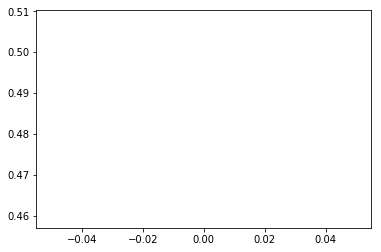

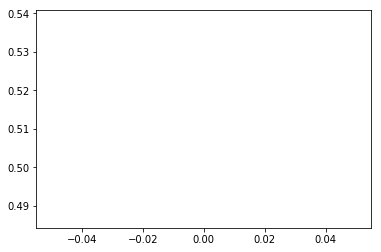

  0%|          | 1/2000 [00:01<57:05,  1.71s/it]

S(a)
[ 0.45310092] [ 0.54689908]
F(a, b)
[ 0.34435254] [ 0.65564746]
F(a, e)
[ 0.48655856] [ 0.51344144]
F(a, f)
[ 0.60869479] [ 0.39130518]
F(a, g)
[ 0.76279169] [ 0.23720831]
F(b, c)
[ 0.60452592] [ 0.39547411]
F(c, d)
[ 0.87017655] [ 0.12982346]
F(e, f)
[ 0.78551084] [ 0.21448918]
F(g, h)
[ 0.83295363] [ 0.16704638]
¬F(a, c)
[ 0.58020431] [ 0.41979569]
¬F(a, d)
[ 0.34049886] [ 0.65950114]
¬F(a, h)
[ 0.39310241] [ 0.60689759]
¬F(b, d)
[ 0.11584246] [ 0.88415754]
¬F(b, f)
[ 0.25089931] [ 0.74910069]
¬F(b, g)
[ 0.19622934] [ 0.80377066]
¬F(b, h)
[ 0.18488193] [ 0.81511807]
¬F(c, e)
[ 0.22728491] [ 0.77271509]
¬F(c, f)
[ 0.17374444] [ 0.82625556]
¬F(c, g)
[ 0.14083052] [ 0.85916948]
¬F(c, h)
[ 0.11496156] [ 0.88503844]
¬F(d, e)
[ 0.22874904] [ 0.77125096]
¬F(d, f)
[ 0.12364519] [ 0.87635481]
¬F(d, g)
[ 0.21299624] [ 0.78700376]
¬F(e, g)
[ 0.22805524] [ 0.77194476]
¬F(e, h)
[ 0.22172362] [ 0.77827638]
¬F(f, g)
[ 0.16027814] [ 0.83972186]
¬F(f, h)
[ 0.11824918] [ 0.88175082]
C(a)
[ 0.3003

  0%|          | 3/2000 [00:04<45:11,  1.36s/it]


KeyboardInterrupt: 

In [48]:
ltn1=LTN(emb_dim,'abcdefghijklmn',[['S',1],['F',2],['C',1]])
kb_train=kb1.union(kb2)
optimizor=torch.optim.Adam(ltn1.parameters(),lr=0.1,weight_decay=0.1)
mone=torch.FloatTensor([-1])
one=torch.FloatTensor([1])
average_prob=[]
averate_loss=[]
for i in tqdm(range(2000)):
    optimizor.zero_grad()
    total_probability=0.0
    total_loss=0.0
    for clause in kb_train.clauses:
        loss,prob=ltn1.forward(clause=clause)
        loss.backward(one)
        total_probability+=prob.data.numpy()[0]
        total_loss+=loss.data.numpy()[0]
    optimizor.step()
    average_prob.append(total_probability/len(kb_train.clauses))
    averate_loss.append(total_loss/len(kb_train.clauses))
    
    if i%100==0:
        plt.plot(average_prob)
        plt.show()
        plt.plot(averate_loss)
        plt.show()
        show_results(ltn1, kb_train)

  0%|          | 0/2000 [00:00<?, ?it/s]

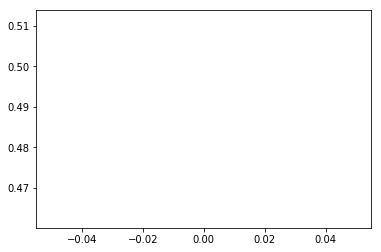

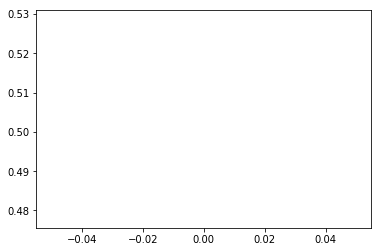

S(a)
[ 0.19260871] [ 0.80739129]
S(e)
[ 0.12007946] [ 0.87992054]
S(f)
[ 0.37159729] [ 0.62840271]
S(g)
[ 0.38323194] [ 0.61676806]
¬S(b)
[ 0.19599307] [ 0.80400693]
¬S(c)
[ 0.13935232] [ 0.86064768]
¬S(d)
[ 0.33385301] [ 0.66614699]
¬S(h)
[ 0.10910249] [ 0.89089751]
F(a, b)
[ 0.21469986] [ 0.78530014]
F(a, e)
[ 0.59396875] [ 0.40603122]
F(a, f)
[ 0.32371378] [ 0.67628622]
F(a, g)
[ 0.66884619] [ 0.33115381]
F(b, c)
[ 0.91960078] [ 0.0803992]
F(c, d)
[ 0.59442633] [ 0.40557367]
F(e, f)
[ 0.61333907] [ 0.38666093]
F(g, h)
[ 0.47030139] [ 0.52969861]
¬F(a, c)
[ 0.26894927] [ 0.73105073]
¬F(a, d)
[ 0.44593477] [ 0.55406523]
¬F(a, h)
[ 0.35522407] [ 0.64477593]
¬F(b, d)
[ 0.11236095] [ 0.88763905]
¬F(b, f)
[ 0.222808] [ 0.777192]
¬F(c, f)
[ 0.50613892] [ 0.49386108]
¬F(e, h)
[ 0.2137562] [ 0.7862438]
C(e)
[ 0.4411689] [ 0.5588311]
¬C(c)
[ 0.15696657] [ 0.84303343]
¬C(g)
[ 0.3099122] [ 0.6900878]
S(i)
[ 0.39362919] [ 0.60637081]
S(n)
[ 0.23999304] [ 0.76000696]
¬S(j)
[ 0.17776263] [ 0.82223

¬F(n, k) ∨ F(k, n)
[ 0.15228343] [ 0.84771657]
¬F(n, l) ∨ F(l, n)
[ 0.60804296] [ 0.39195704]
¬F(n, m) ∨ F(m, n)
[ 0.21188509] [ 0.78811491]
¬F(n, n) ∨ F(n, n)
[ 0.46631479] [ 0.53368521]
F(i, i) ∨ F(i, j) ∨ F(i, k) ∨ F(i, l) ∨ F(i, m) ∨ F(i, n)
[ 0.40164405] [ 0.59835595]
F(j, i) ∨ F(j, j) ∨ F(j, k) ∨ F(j, l) ∨ F(j, m) ∨ F(j, n)
[ 0.67040086] [ 0.32959911]
F(k, i) ∨ F(k, j) ∨ F(k, k) ∨ F(k, l) ∨ F(k, m) ∨ F(k, n)
[ 0.13603121] [ 0.86396879]
F(l, i) ∨ F(l, j) ∨ F(l, k) ∨ F(l, l) ∨ F(l, m) ∨ F(l, n)
[ 0.29650605] [ 0.70349395]
F(m, i) ∨ F(m, j) ∨ F(m, k) ∨ F(m, l) ∨ F(m, m) ∨ F(m, n)
[ 0.15639806] [ 0.84360194]
F(n, i) ∨ F(n, j) ∨ F(n, k) ∨ F(n, l) ∨ F(n, m) ∨ F(n, n)
[ 0.18601418] [ 0.81398582]
¬S(i) ∨ ¬F(i, i) ∨ S(i)
[ 0.33238387] [ 0.66761613]
¬S(i) ∨ ¬F(i, j) ∨ S(j)
[ 0.59835595] [ 0.40164405]
¬S(i) ∨ ¬F(i, k) ∨ S(k)
[ 0.23511189] [ 0.76488811]
¬S(i) ∨ ¬F(i, l) ∨ S(l)
[ 0.34373367] [ 0.65626633]
¬S(i) ∨ ¬F(i, m) ∨ S(m)
[ 0.22899652] [ 0.77100348]
¬S(i) ∨ ¬F(i, n) ∨ S(n)
[ 0.23999304

  0%|          | 1/2000 [00:03<1:49:13,  3.28s/it]


¬S(m) ∨ ¬F(m, l) ∨ S(l)
[ 0.1613239] [ 0.8386761]
¬S(m) ∨ ¬F(m, m) ∨ S(m)
[ 0.1613239] [ 0.8386761]
¬S(m) ∨ ¬F(m, n) ∨ S(n)
[ 0.1613239] [ 0.8386761]
¬S(n) ∨ ¬F(n, i) ∨ S(i)
[ 0.39362919] [ 0.60637081]
¬S(n) ∨ ¬F(n, j) ∨ S(j)
[ 0.76000696] [ 0.23999304]
¬S(n) ∨ ¬F(n, k) ∨ S(k)
[ 0.15228343] [ 0.84771657]
¬S(n) ∨ ¬F(n, l) ∨ S(l)
[ 0.60804296] [ 0.39195704]
¬S(n) ∨ ¬F(n, m) ∨ S(m)
[ 0.21188509] [ 0.78811491]
¬S(n) ∨ ¬F(n, n) ∨ S(n)
[ 0.23999304] [ 0.76000696]
¬S(i) ∨ C(i)
[ 0.60637081] [ 0.39362919]
¬S(j) ∨ C(j)
[ 0.17776263] [ 0.82223737]
¬S(k) ∨ C(k)
[ 0.11741674] [ 0.88258326]
¬S(l) ∨ C(l)
[ 0.31064707] [ 0.68935293]
¬S(m) ∨ C(m)
[ 0.1613239] [ 0.8386761]
¬S(n) ∨ C(n)
[ 0.45708627] [ 0.54291373]
242


  5%|▌         | 100/2000 [01:57<37:12,  1.18s/it]

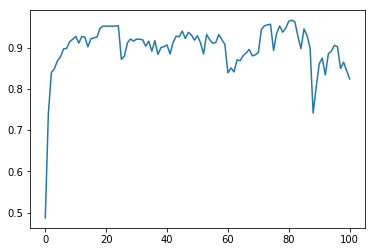

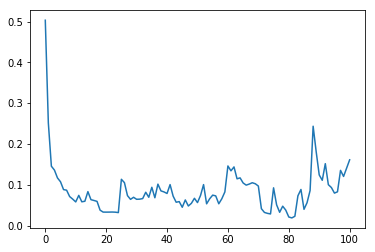

S(a)
[ 0.47170275] [ 0.52829725]
F(a, b)
[ 0.74202216] [ 0.25797787]
F(a, g)
[ 0.53678906] [ 0.46321091]
F(b, c)
[ 0.99278444] [ 0.00721557]
F(c, d)
[ 0.84484255] [ 0.15515746]
F(e, f)
[ 0.9999997] [  3.17459467e-07]
F(g, h)
[ 0.99999714] [  2.84739804e-06]
¬C(f)
[ 0.99992144] [  7.85589218e-05]
F(i, m)
[ 0.92230612] [ 0.07769386]
F(k, l)
[ 0.99999481] [  5.15915735e-06]
¬F(a, b) ∨ F(b, a)
[ 0.25797784] [ 0.74202216]
¬F(a, e) ∨ F(e, a)
[ 0.91930658] [ 0.08069342]
¬F(a, f) ∨ F(f, a)
[ 0.93054909] [ 0.06945091]
¬F(a, g) ∨ F(g, a)
[ 0.46321094] [ 0.53678906]
¬F(c, d) ∨ F(d, c)
[ 0.15515745] [ 0.84484255]
¬F(e, c) ∨ F(c, e)
[ 0.91999334] [ 0.08000666]
¬F(f, c) ∨ F(c, f)
[ 0.24450028] [ 0.75549972]
¬F(g, c) ∨ F(c, g)
[ 0.49398708] [ 0.50601292]
¬F(g, e) ∨ F(e, g)
[ 0.96437687] [ 0.03562313]
¬F(g, f) ∨ F(f, g)
[ 0.99144554] [ 0.00855446]
¬F(h, a) ∨ F(a, h)
[ 0.99970561] [ 0.00029439]
¬F(h, c) ∨ F(c, h)
[ 0.23266315] [ 0.76733685]
¬F(h, d) ∨ F(d, h)
[ 0.943708] [ 0.056292]
F(b, a) ∨ F(b, b) ∨

  5%|▌         | 101/2000 [01:59<37:27,  1.18s/it]

¬S(i) ∨ ¬F(i, j) ∨ S(j)
[ 0.99606162] [ 0.00393838]
¬S(n) ∨ ¬F(n, j) ∨ S(j)
[ 0.92309225] [ 0.07690775]
¬S(n) ∨ ¬F(n, l) ∨ S(l)
[ 0.72630739] [ 0.27369261]
¬S(n) ∨ C(n)
[ 0.92309225] [ 0.07690775]
53


 10%|█         | 200/2000 [38:15<5:44:22, 11.48s/it] 

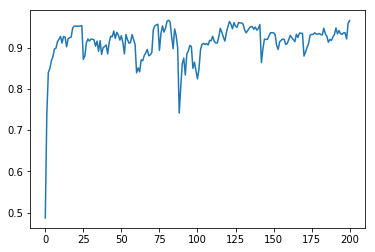

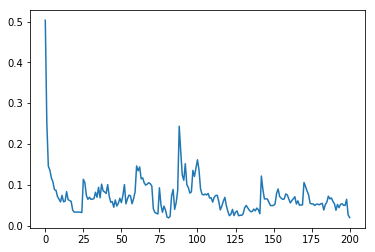

F(b, c)
[ 0.99999875] [  1.23286486e-06]
¬F(a, a)
[ 0.21444845] [ 0.78555155]
¬F(c, c)
[ 0.82746673] [ 0.17253327]
¬F(e, e)
[ 0.93687207] [ 0.06312793]
¬F(f, f)
[ 0.13774604] [ 0.86225396]
¬F(a, a) ∨ F(a, a)
[ 0.21444845] [ 0.78555155]
¬F(a, b) ∨ F(b, a)
[ 0.99997365] [  2.63452530e-05]
¬F(a, e) ∨ F(e, a)
[ 0.89846939] [ 0.10153063]
¬F(a, f) ∨ F(f, a)
[ 0.99595106] [ 0.00404894]
¬F(c, c) ∨ F(c, c)
[ 0.17253327] [ 0.82746673]
¬F(c, d) ∨ F(d, c)
[ 0.98136491] [ 0.01863509]
¬F(e, b) ∨ F(b, e)
[ 0.98141241] [ 0.01858759]
¬F(e, f) ∨ F(f, e)
[ 0.69578242] [ 0.30421761]
¬F(f, c) ∨ F(c, f)
[ 0.61604577] [ 0.38395423]
¬F(f, f) ∨ F(f, f)
[ 0.13774604] [ 0.86225396]
¬F(g, b) ∨ F(b, g)
[ 0.99996984] [  3.01599503e-05]
¬F(g, d) ∨ F(d, g)
[ 0.62184489] [ 0.37815511]
¬F(g, e) ∨ F(e, g)
[ 0.99698478] [ 0.00301524]
¬F(g, f) ∨ F(f, g)
[ 0.95058894] [ 0.04941104]
¬F(h, a) ∨ F(a, h)
[ 0.12074471] [ 0.87925529]
¬F(h, b) ∨ F(b, h)
[ 0.98601645] [ 0.01398355]
¬F(h, c) ∨ F(c, h)
[ 0.99727154] [ 0.00272846]
¬F

 10%|█         | 201/2000 [38:20<5:43:05, 11.44s/it]

¬S(i) ∨ ¬F(i, m) ∨ S(m)
[ 0.9833225] [ 0.01667752]
¬S(n) ∨ ¬F(n, l) ∨ S(l)
[ 0.84578425] [ 0.15421575]
¬S(n) ∨ ¬F(n, m) ∨ S(m)
[ 0.51637745] [ 0.48362255]
¬S(i) ∨ C(i)
[ 0.99165386] [ 0.00834614]
¬S(n) ∨ C(n)
[ 0.80462348] [ 0.1953765]
61


 15%|█▌        | 300/2000 [40:22<3:48:46,  8.07s/it]

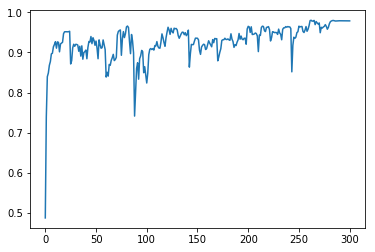

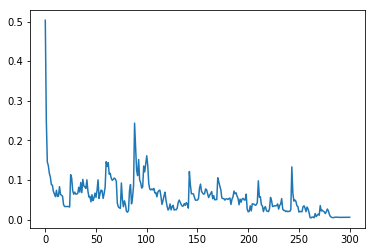

¬F(a, a)
[ 0.81771851] [ 0.18228149]
¬F(c, c)
[ 0.99868006] [ 0.00131994]
¬F(d, d)
[ 0.75381738] [ 0.24618262]
¬F(e, e)
[ 0.76106048] [ 0.23893952]
¬F(f, f)
[ 0.83809948] [ 0.16190052]
¬F(a, a) ∨ F(a, a)
[ 0.18228149] [ 0.81771851]
¬F(a, b) ∨ F(b, a)
[ 0.98077899] [ 0.019221]
¬F(a, f) ∨ F(f, a)
[ 0.35172421] [ 0.64827579]
¬F(a, g) ∨ F(g, a)
[ 0.1004706] [ 0.8995294]
¬F(b, c) ∨ F(c, b)
[ 0.99587905] [ 0.00412095]
¬F(d, d) ∨ F(d, d)
[ 0.24618262] [ 0.75381738]
¬F(e, b) ∨ F(b, e)
[ 0.76380873] [ 0.23619127]
¬F(e, c) ∨ F(c, e)
[ 0.11764681] [ 0.88235319]
¬F(e, e) ∨ F(e, e)
[ 0.23893952] [ 0.76106048]
¬F(e, f) ∨ F(f, e)
[ 0.95120144] [ 0.04879858]
¬F(f, b) ∨ F(b, f)
[ 0.64580101] [ 0.35419899]
¬F(f, c) ∨ F(c, f)
[ 0.29759634] [ 0.70240366]
¬F(f, f) ∨ F(f, f)
[ 0.16190052] [ 0.83809948]
¬F(g, b) ∨ F(b, g)
[ 0.45622957] [ 0.54377043]
¬F(g, c) ∨ F(c, g)
[ 0.99794191] [ 0.00205811]
¬F(g, d) ∨ F(d, g)
[ 0.98924047] [ 0.01075953]
¬F(g, h) ∨ F(h, g)
[ 0.21624655] [ 0.78375345]
¬F(h, b) ∨ F(b, h)
[

 15%|█▌        | 301/2000 [40:28<3:48:28,  8.07s/it]

¬S(n) ∨ ¬F(n, j) ∨ S(j)
[ 0.8170979] [ 0.1829021]
¬S(n) ∨ ¬F(n, k) ∨ S(k)
[ 0.72188848] [ 0.27811152]
¬S(n) ∨ ¬F(n, l) ∨ S(l)
[ 0.77957046] [ 0.22042954]
¬S(n) ∨ ¬F(n, m) ∨ S(m)
[ 0.78598416] [ 0.21401584]
¬S(i) ∨ C(i)
[ 0.77049351] [ 0.22950646]
¬S(n) ∨ C(n)
[ 0.88722503] [ 0.11277499]
64


 20%|██        | 400/2000 [42:43<2:50:52,  6.41s/it]

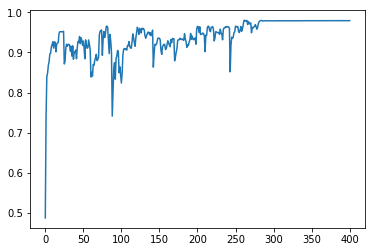

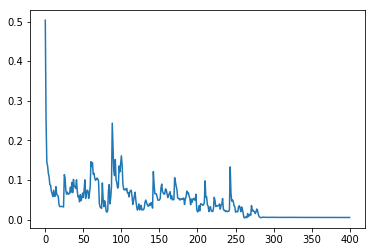

¬F(a, a)
[ 0.94227916] [ 0.05772084]
¬F(b, b)
[ 0.5662114] [ 0.4337886]
¬F(c, c)
[ 0.95931095] [ 0.04068905]
¬F(d, d)
[ 0.88247007] [ 0.11752993]
¬F(e, e)
[ 0.88848454] [ 0.11151546]
¬F(a, b) ∨ F(b, a)
[ 0.9951871] [ 0.00481287]
¬F(a, e) ∨ F(e, a)
[ 0.18675053] [ 0.81324947]
¬F(a, f) ∨ F(f, a)
[ 0.85948515] [ 0.14051485]
¬F(a, g) ∨ F(g, a)
[ 0.39564157] [ 0.60435843]
¬F(b, b) ∨ F(b, b)
[ 0.4337886] [ 0.5662114]
¬F(b, c) ∨ F(c, b)
[ 0.98988956] [ 0.01011044]
¬F(c, d) ∨ F(d, c)
[ 0.76924169] [ 0.23075828]
¬F(d, d) ∨ F(d, d)
[ 0.11752993] [ 0.88247007]
¬F(e, b) ∨ F(b, e)
[ 0.89215994] [ 0.10784006]
¬F(e, e) ∨ F(e, e)
[ 0.11151546] [ 0.88848454]
¬F(e, f) ∨ F(f, e)
[ 0.9604035] [ 0.03959649]
¬F(f, b) ∨ F(b, f)
[ 0.13536119] [ 0.86463881]
¬F(f, c) ∨ F(c, f)
[ 0.39640367] [ 0.60359633]
¬F(g, c) ∨ F(c, g)
[ 0.99847978] [ 0.0015202]
¬F(g, d) ∨ F(d, g)
[ 0.99703431] [ 0.00296569]
¬F(h, b) ∨ F(b, h)
[ 0.79376733] [ 0.20623267]
¬F(h, c) ∨ F(c, h)
[ 0.16823101] [ 0.83176899]
¬F(h, d) ∨ F(d, h)
[ 0.

 20%|██        | 401/2000 [42:45<2:50:30,  6.40s/it]


[ 0.4430421] [ 0.5569579]
¬S(i) ∨ ¬F(i, j) ∨ S(j)
[ 0.98982459] [ 0.01017541]
¬S(i) ∨ ¬F(i, m) ∨ S(m)
[ 0.98916864] [ 0.01083134]
¬S(n) ∨ ¬F(n, j) ∨ S(j)
[ 0.5569579] [ 0.4430421]
¬S(n) ∨ ¬F(n, k) ∨ S(k)
[ 0.15449661] [ 0.84550339]
¬S(n) ∨ ¬F(n, l) ∨ S(l)
[ 0.10672349] [ 0.89327651]
¬S(n) ∨ ¬F(n, m) ∨ S(m)
[ 0.45215434] [ 0.54784566]
¬S(i) ∨ C(i)
[ 0.95245147] [ 0.04754852]
¬S(n) ∨ C(n)
[ 0.94736052] [ 0.05263951]
59


 25%|██▌       | 500/2000 [44:57<2:14:51,  5.39s/it]

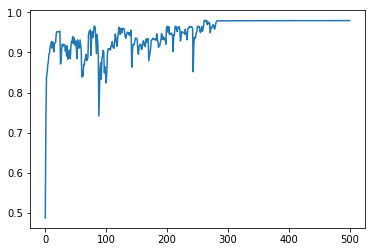

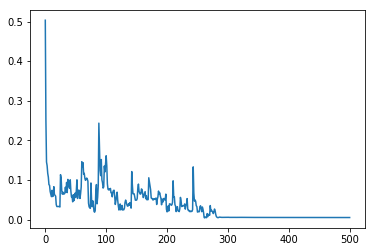

¬F(a, a)
[ 0.93304425] [ 0.06695575]
¬F(b, b)
[ 0.71244764] [ 0.28755236]
¬F(c, c)
[ 0.91557848] [ 0.08442152]
¬F(d, d)
[ 0.87437284] [ 0.12562716]
¬F(e, e)
[ 0.92114156] [ 0.07885844]
¬F(f, f)
[ 0.16686696] [ 0.83313304]
¬F(a, b) ∨ F(b, a)
[ 0.99395347] [ 0.00604654]
¬F(a, e) ∨ F(e, a)
[ 0.14800614] [ 0.85199386]
¬F(a, f) ∨ F(f, a)
[ 0.7830795] [ 0.21692048]
¬F(a, g) ∨ F(g, a)
[ 0.273462] [ 0.726538]
¬F(b, b) ∨ F(b, b)
[ 0.28755236] [ 0.71244764]
¬F(b, c) ∨ F(c, b)
[ 0.99097896] [ 0.00902104]
¬F(c, d) ∨ F(d, c)
[ 0.89634204] [ 0.10365795]
¬F(d, d) ∨ F(d, d)
[ 0.12562716] [ 0.87437284]
¬F(e, b) ∨ F(b, e)
[ 0.50052065] [ 0.49947935]
¬F(e, f) ∨ F(f, e)
[ 0.92330313] [ 0.0766969]
¬F(f, c) ∨ F(c, f)
[ 0.11913621] [ 0.88086379]
¬F(f, f) ∨ F(f, f)
[ 0.16686696] [ 0.83313304]
¬F(g, c) ∨ F(c, g)
[ 0.9985078] [ 0.00149223]
¬F(g, d) ∨ F(d, g)
[ 0.99334282] [ 0.00665718]
¬F(h, b) ∨ F(b, h)
[ 0.38718927] [ 0.61281073]
¬F(h, d) ∨ F(d, h)
[ 0.85112679] [ 0.14887321]
¬F(h, e) ∨ F(e, h)
[ 0.7997452] [

 25%|██▌       | 501/2000 [44:59<2:14:37,  5.39s/it]

¬F(l, j) ∨ F(j, l)
[ 0.22964013] [ 0.77035987]
¬F(m, j) ∨ F(j, m)
[ 0.36978579] [ 0.63021421]
¬F(m, k) ∨ F(k, m)
[ 0.44647479] [ 0.55352521]
¬F(m, l) ∨ F(l, m)
[ 0.21854746] [ 0.78145254]
¬F(m, n) ∨ F(n, m)
[ 0.64961505] [ 0.35038495]
¬F(n, j) ∨ F(j, n)
[ 0.31506622] [ 0.68493378]
F(j, i) ∨ F(j, j) ∨ F(j, k) ∨ F(j, l) ∨ F(j, m) ∨ F(j, n)
[ 0.29299599] [ 0.70700401]
F(n, i) ∨ F(n, j) ∨ F(n, k) ∨ F(n, l) ∨ F(n, m) ∨ F(n, n)
[ 0.64961505] [ 0.35038495]
¬S(i) ∨ ¬F(i, j) ∨ S(j)
[ 0.98916316] [ 0.01083686]
¬S(i) ∨ ¬F(i, m) ∨ S(m)
[ 0.99001408] [ 0.00998591]
¬S(n) ∨ ¬F(n, j) ∨ S(j)
[ 0.31506622] [ 0.68493378]
¬S(n) ∨ ¬F(n, m) ∨ S(m)
[ 0.35038495] [ 0.64961505]
¬S(i) ∨ C(i)
[ 0.94790262] [ 0.05209739]
¬S(n) ∨ C(n)
[ 0.9281044] [ 0.07189558]
54


 30%|███       | 600/2000 [47:15<1:50:15,  4.73s/it]

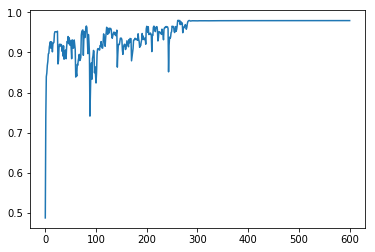

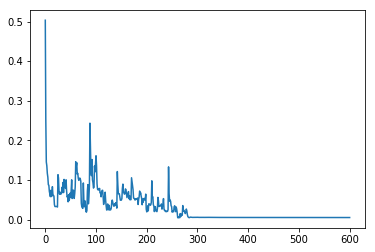

¬F(a, a)
[ 0.9386189] [ 0.0613811]
¬F(b, b)
[ 0.82694358] [ 0.17305642]
¬F(c, c)
[ 0.94033772] [ 0.05966228]
¬F(d, d)
[ 0.88877118] [ 0.11122882]
¬F(e, e)
[ 0.93900734] [ 0.06099266]
¬F(f, f)
[ 0.2710948] [ 0.7289052]
¬F(a, b) ∨ F(b, a)
[ 0.99524802] [ 0.00475196]
¬F(a, e) ∨ F(e, a)
[ 0.11102217] [ 0.88897783]
¬F(a, f) ∨ F(f, a)
[ 0.70395494] [ 0.29604509]
¬F(a, g) ∨ F(g, a)
[ 0.22727114] [ 0.77272886]
¬F(b, b) ∨ F(b, b)
[ 0.17305642] [ 0.82694358]
¬F(b, c) ∨ F(c, b)
[ 0.9917351] [ 0.0082649]
¬F(c, d) ∨ F(d, c)
[ 0.93956178] [ 0.06043824]
¬F(d, d) ∨ F(d, d)
[ 0.11122882] [ 0.88877118]
¬F(e, b) ∨ F(b, e)
[ 0.3217802] [ 0.6782198]
¬F(e, f) ∨ F(f, e)
[ 0.87392938] [ 0.12607065]
¬F(f, f) ∨ F(f, f)
[ 0.2710948] [ 0.7289052]
¬F(g, c) ∨ F(c, g)
[ 0.99853116] [ 0.00146882]
¬F(g, d) ∨ F(d, g)
[ 0.99216121] [ 0.00783879]
¬F(g, h) ∨ F(h, g)
[ 0.12526125] [ 0.87473875]
¬F(h, b) ∨ F(b, h)
[ 0.1334365] [ 0.8665635]
¬F(h, d) ∨ F(d, h)
[ 0.89391571] [ 0.10608429]
¬F(h, e) ∨ F(e, h)
[ 0.80928171] [ 0.1

 30%|███       | 601/2000 [47:17<1:50:05,  4.72s/it]

¬S(i) ∨ ¬F(i, m) ∨ S(m)
[ 0.98937201] [ 0.01062796]
¬S(n) ∨ ¬F(n, j) ∨ S(j)
[ 0.20893502] [ 0.79106498]
¬S(n) ∨ ¬F(n, m) ∨ S(m)
[ 0.30373502] [ 0.69626498]
¬S(i) ∨ C(i)
[ 0.93821597] [ 0.06178404]
¬S(n) ∨ C(n)
[ 0.92621475] [ 0.07378525]
53


 35%|███▌      | 700/2000 [49:27<1:31:51,  4.24s/it]

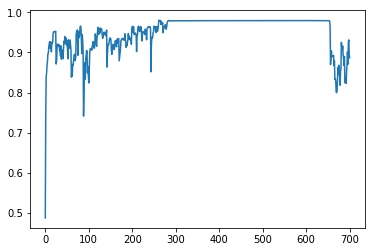

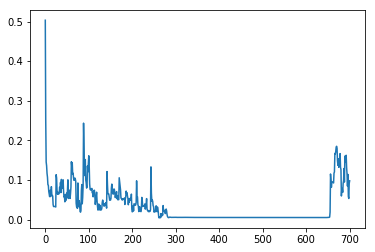

S(f)
[ 0.99999785] [  2.14086526e-06]
S(g)
[ 0.10180873] [ 0.89819127]
F(a, g)
[ 0.52222365] [ 0.47777635]
F(b, c)
[ 0.99948871] [ 0.00051128]
S(n)
[ 0.15369612] [ 0.84630388]
F(k, l)
[ 0.13153595] [ 0.86846405]
¬F(e, e)
[ 0.99999797] [  2.02655792e-06]
¬F(f, f)
[ 0.99811745] [ 0.00188255]
¬F(g, g)
[ 0.99999893] [  1.07288361e-06]
¬F(a, b) ∨ F(b, a)
[ 0.99999976] [  2.38418579e-07]
¬F(a, f) ∨ F(f, a)
[ 0.99718744] [ 0.00281254]
¬F(c, d) ∨ F(d, c)
[ 0.9923591] [ 0.0076409]
¬F(e, b) ∨ F(b, e)
[ 0.99999499] [  5.00679016e-06]
¬F(f, b) ∨ F(b, f)
[ 0.9958533] [ 0.0041467]
¬F(g, a) ∨ F(a, g)
[ 0.52222365] [ 0.47777635]
¬F(g, c) ∨ F(c, g)
[ 0.9999088] [  9.11951065e-05]
¬F(g, d) ∨ F(d, g)
[ 0.99990356] [  9.64403152e-05]
¬F(g, e) ∨ F(e, g)
[ 0.51560664] [ 0.48439336]
¬F(g, h) ∨ F(h, g)
[ 0.99769849] [ 0.00230151]
¬F(h, c) ∨ F(c, h)
[ 0.61098397] [ 0.38901603]
¬F(h, d) ∨ F(d, h)
[ 0.19373512] [ 0.80626488]
F(b, a) ∨ F(b, b) ∨ F(b, c) ∨ F(b, d) ∨ F(b, e) ∨ F(b, f) ∨ F(b, g) ∨ F(b, h)
[ 0.991119

 35%|███▌      | 701/2000 [49:30<1:31:44,  4.24s/it]

¬S(n) ∨ ¬F(n, k) ∨ S(k)
[ 0.84630388] [ 0.15369612]
¬S(n) ∨ ¬F(n, l) ∨ S(l)
[ 0.84630388] [ 0.15369612]
¬S(i) ∨ C(i)
[ 0.99932897] [ 0.00067103]
¬S(n) ∨ C(n)
[ 0.84630388] [ 0.15369612]
55


 40%|████      | 800/2000 [51:32<1:17:19,  3.87s/it]

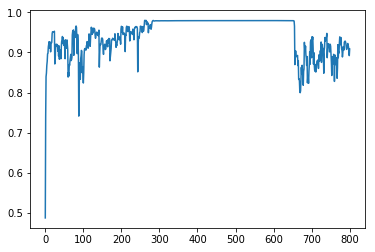

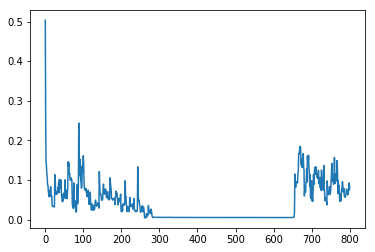

F(a, g)
[ 0.99999988] [  1.40651380e-07]
F(b, c)
[ 0.16712546] [ 0.83287454]
F(c, d)
[ 0.99972343] [ 0.00027654]
¬S(l)
[ 0.13737231] [ 0.86262769]
F(k, l)
[ 0.19921362] [ 0.80078638]
F(m, n)
[ 0.99998176] [  1.82602689e-05]
¬F(i, l)
[ 0.13775647] [ 0.86224353]
¬F(a, a)
[ 0.99999964] [  3.57627869e-07]
¬F(c, c)
[ 0.93160695] [ 0.06839305]
¬F(e, e)
[ 0.99521554] [ 0.00478446]
¬F(f, f)
[ 0.99994349] [  5.65052032e-05]
¬F(a, b) ∨ F(b, a)
[ 0.99999487] [  5.10095288e-06]
¬F(b, c) ∨ F(c, b)
[ 0.83287454] [ 0.16712546]
¬F(e, b) ∨ F(b, e)
[ 0.99971253] [ 0.00028747]
¬F(e, c) ∨ F(c, e)
[ 0.15688038] [ 0.84311962]
¬F(e, f) ∨ F(f, e)
[ 0.96599483] [ 0.03400516]
¬F(f, b) ∨ F(b, f)
[ 0.96580255] [ 0.03419746]
¬F(g, a) ∨ F(a, g)
[ 0.14561445] [ 0.85438555]
¬F(g, c) ∨ F(c, g)
[ 0.99996179] [  3.81888858e-05]
¬F(g, d) ∨ F(d, g)
[ 0.99993318] [  6.67920831e-05]
¬F(g, e) ∨ F(e, g)
[ 0.9911381] [ 0.00886191]
¬F(g, h) ∨ F(h, g)
[ 0.99822253] [ 0.00177747]
¬F(h, a) ∨ F(a, h)
[ 0.99996257] [  3.74317169e-05

 40%|████      | 801/2000 [51:36<1:17:14,  3.87s/it]

F(l, i) ∨ F(l, j) ∨ F(l, k) ∨ F(l, l) ∨ F(l, m) ∨ F(l, n)
[ 0.45630437] [ 0.54369563]
F(m, i) ∨ F(m, j) ∨ F(m, k) ∨ F(m, l) ∨ F(m, m) ∨ F(m, n)
[ 0.84405118] [ 0.15594883]
¬S(i) ∨ ¬F(i, j) ∨ S(j)
[ 0.99922669] [ 0.00077331]
¬S(i) ∨ ¬F(i, l) ∨ S(l)
[ 0.13775647] [ 0.86224353]
¬S(i) ∨ ¬F(i, m) ∨ S(m)
[ 0.99391568] [ 0.00608429]
¬S(l) ∨ ¬F(l, l) ∨ S(l)
[ 0.13737231] [ 0.86262769]
¬S(n) ∨ ¬F(n, j) ∨ S(j)
[ 0.99843675] [ 0.00156325]
¬S(n) ∨ ¬F(n, m) ∨ S(m)
[ 0.99329364] [ 0.00670636]
¬S(i) ∨ C(i)
[ 0.72049576] [ 0.27950424]
¬S(l) ∨ C(l)
[ 0.13737231] [ 0.86262769]
¬S(n) ∨ C(n)
[ 0.98370665] [ 0.01629335]
64


 45%|████▌     | 900/2000 [53:50<1:05:48,  3.59s/it]

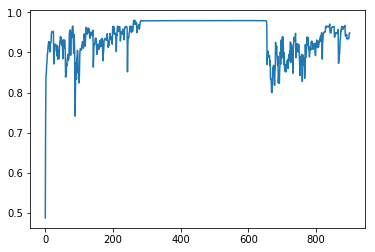

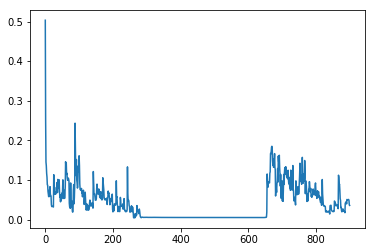

F(a, g)
[ 0.99985498] [ 0.00014503]
F(b, c)
[ 0.99995583] [  4.41414304e-05]
¬F(a, a)
[ 0.99934918] [ 0.00065082]
¬F(c, c)
[ 0.99712223] [ 0.00287777]
¬F(e, e)
[ 0.99996102] [  3.89814377e-05]
¬F(f, f)
[ 0.94813585] [ 0.05186415]
¬F(g, g)
[ 0.99947089] [ 0.00052911]
¬F(h, h)
[ 0.92897058] [ 0.07102942]
¬F(a, b) ∨ F(b, a)
[ 0.96136659] [ 0.03863341]
¬F(a, f) ∨ F(f, a)
[ 0.24463123] [ 0.75536877]
¬F(c, d) ∨ F(d, c)
[ 0.93971229] [ 0.06028773]
¬F(e, b) ∨ F(b, e)
[ 0.99989516] [ 0.00010482]
¬F(f, b) ∨ F(b, f)
[ 0.98629934] [ 0.01370066]
¬F(g, a) ∨ F(a, g)
[ 0.99730116] [ 0.00269884]
¬F(g, b) ∨ F(b, g)
[ 0.40041417] [ 0.59958583]
¬F(g, c) ∨ F(c, g)
[ 0.99834228] [ 0.00165774]
¬F(g, d) ∨ F(d, g)
[ 0.9963758] [ 0.00362421]
¬F(g, h) ∨ F(h, g)
[ 0.46710366] [ 0.53289634]
¬F(h, a) ∨ F(a, h)
[ 0.94408661] [ 0.05591339]
¬F(h, b) ∨ F(b, h)
[ 0.7648409] [ 0.2351591]
¬F(h, c) ∨ F(c, h)
[ 0.90833646] [ 0.09166354]
¬F(h, d) ∨ F(d, h)
[ 0.90023029] [ 0.09976971]
¬F(h, f) ∨ F(f, h)
[ 0.79845536] [ 0.2015

 45%|████▌     | 901/2000 [53:54<1:05:45,  3.59s/it]

¬S(i) ∨ ¬F(i, m) ∨ S(m)
[ 0.98548359] [ 0.01451641]
¬S(n) ∨ ¬F(n, k) ∨ S(k)
[ 0.2152642] [ 0.7847358]
¬S(n) ∨ ¬F(n, l) ∨ S(l)
[ 0.31840742] [ 0.68159258]
¬S(i) ∨ C(i)
[ 0.92883641] [ 0.0711636]
¬S(n) ∨ C(n)
[ 0.97896272] [ 0.02103727]
56


 50%|█████     | 1000/2000 [56:01<56:01,  3.36s/it] 

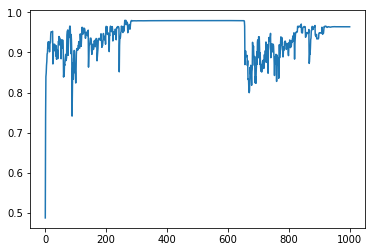

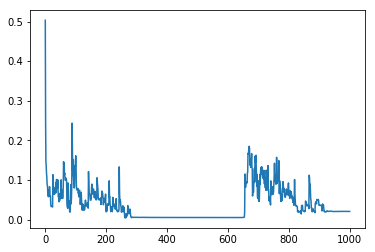

F(b, c)
[ 0.99751025] [ 0.00248976]
¬F(a, a)
[ 0.88180995] [ 0.11819005]
¬F(b, b)
[ 0.32514846] [ 0.67485154]
¬F(c, c)
[ 0.87544018] [ 0.12455982]
¬F(d, d)
[ 0.95283264] [ 0.04716736]
¬F(e, e)
[ 0.91368902] [ 0.08631098]
¬F(a, a) ∨ F(a, a)
[ 0.11819005] [ 0.88180995]
¬F(a, b) ∨ F(b, a)
[ 0.99703693] [ 0.00296309]
¬F(a, e) ∨ F(e, a)
[ 0.48484963] [ 0.51515037]
¬F(a, f) ∨ F(f, a)
[ 0.97407836] [ 0.02592161]
¬F(a, g) ∨ F(g, a)
[ 0.49464864] [ 0.50535136]
¬F(b, b) ∨ F(b, b)
[ 0.32514846] [ 0.67485154]
¬F(c, c) ∨ F(c, c)
[ 0.12455982] [ 0.87544018]
¬F(c, d) ∨ F(d, c)
[ 0.44068998] [ 0.55931002]
¬F(e, b) ∨ F(b, e)
[ 0.99654788] [ 0.00345212]
¬F(e, f) ∨ F(f, e)
[ 0.99069977] [ 0.00930025]
¬F(g, c) ∨ F(c, g)
[ 0.99729806] [ 0.00270193]
¬F(g, d) ∨ F(d, g)
[ 0.99913281] [ 0.0008672]
¬F(g, h) ∨ F(h, g)
[ 0.16988158] [ 0.83011842]
¬F(h, b) ∨ F(b, h)
[ 0.67895204] [ 0.32104796]
¬F(h, c) ∨ F(c, h)
[ 0.57009488] [ 0.42990512]
¬F(h, d) ∨ F(d, h)
[ 0.92050415] [ 0.07949585]
¬F(h, e) ∨ F(e, h)
[ 0.26682

 50%|█████     | 1001/2000 [56:04<55:57,  3.36s/it]

¬S(n) ∨ ¬F(n, j) ∨ S(j)
[ 0.54001909] [ 0.45998091]
¬S(n) ∨ ¬F(n, k) ∨ S(k)
[ 0.13301283] [ 0.86698717]
¬S(n) ∨ ¬F(n, m) ∨ S(m)
[ 0.38270384] [ 0.61729616]
¬S(i) ∨ C(i)
[ 0.95587194] [ 0.04412808]
¬S(n) ∨ C(n)
[ 0.95811409] [ 0.04188592]
57


 50%|█████     | 1004/2000 [56:08<55:41,  3.35s/it]

In [ ]:
kb_train2=kb1.union(kb2).union(gkb1).union(gkb2)
ltn2=LTN(emb_dim,'abcdefghijklmn',[['S',1],['F',2],['C',1]])
optimizor=torch.optim.Adam(ltn2.parameters(),lr=0.1,weight_decay=0.1)
mone=torch.FloatTensor([-1])
one=torch.FloatTensor([1])
average_prob2=[]
average_loss2=[]
for i in tqdm(range(2000)):
    optimizor.zero_grad()
    total_probability=0.0
    total_loss=0.0
    for clause in kb_train.clauses:
        loss,prob=ltn2.forward(clause=clause)
        loss.backward(one)
        total_probability+=prob.data.numpy()[0]
        total_loss+=loss.data.numpy()[0]
    optimizor.step()
    average_prob2.append(total_probability/len(kb_train.clauses))
    average_loss2.append(total_loss/len(kb_train.clauses))
    if i%100==0:
        plt.plot(average_prob2)
        plt.show()
        plt.plot(average_loss2)
        plt.show()
        show_results(ltn2,kb_train2)

In [37]:
show_results(ltn1,kb2)

0


In [28]:
import pandas as pd
import numpy

In [29]:
def get_DF_S(model,constants):
    constants=list(constants)
    df=pd.DataFrame(index=constants,columns=['S'])
    for a in constants:
        clause=Clause(1,1,[Predicate(name='S',variables=[a],negation=False)])
        result=model.forward(clause)
        df['S'][a]='%0.2f'%result[1].data.numpy()[0]
    return df

In [30]:
def get_DF_C(model,constants):
    constants=list(constants)
    df=pd.DataFrame(index=constants,columns=['C'])
    for a in constants:
        clause=Clause(1,1,[Predicate(name='C',variables=[a],negation=False)])
        result=model.forward(clause)
        df['C'][a]='%0.2f'%result[1].data.numpy()[0]
    return df

In [31]:
def get_DF_F(model,constants):
    constants=list(constants)
    df=pd.DataFrame(index=constants, columns=constants)
    for a in constants:
        for b in constants:
#             if a>=b:
#                 df[b][a]='-'
#                 continue
            clause=Clause(1,1,[Predicate(name='F',variables=[a,b],negation=False)])
            result=model.forward(clause)
            df[b][a]='%0.2f'%result[1].data.numpy()[0]
    return df

In [32]:
def get_DF(model,constants):
    df1=get_DF_S(model,constants)
    df2=get_DF_C(model,constants)
    df3=get_DF_F(model,constants)
    df=pd.concat([df1,df2,df3],axis=1)
    return df

In [33]:
get_DF(ltn1,'abcdefgh')

,S,C,a,b,c,d,e,f,g,h
a,0.99,0.99,0.94,1.00,0.00,0.00,1.00,1.00,0.99,0.00
b,0.00,0.01,0.00,0.97,0.99,0.01,0.00,0.00,0.00,0.00
c,0.01,0.01,0.00,0.00,0.97,0.99,0.00,0.00,0.00,0.01
d,0.00,0.01,0.00,0.00,0.05,0.96,0.00,0.00,0.00,0.00
e,0.99,0.98,0.86,0.79,0.00,0.00,0.92,0.99,0.01,0.00
f,0.99,0.01,0.24,0.45,0.06,0.00,0.12,0.34,0.00,0.00
g,0.99,0.01,0.78,0.02,1.00,1.00,0.03,0.00,0.00,1.00
h,0.00,0.01,0.02,0.26,0.16,0.76,0.71,0.96,0.95,0.00


In [34]:
get_DF(ltn1,'ijklmn')

,S,C,i,j,k,l,m,n
i,0.99,0.06,0.01,1.00,0.00,0.00,0.99,0.00
j,0.01,0.02,0.14,0.65,0.00,0.00,0.00,0.01
k,0.01,0.06,0.01,0.24,0.98,0.99,0.00,0.01
l,0.01,0.04,0.01,0.60,0.93,0.98,0.00,0.00
m,0.01,0.04,0.97,0.12,0.28,0.23,0.00,0.99
n,0.99,0.08,0.00,0.11,0.16,0.14,0.14,0.05


In [41]:
get_DF(ltn2,'abcdefgh')

,S,C,a,b,c,d,e,f,g,h
a,1.00,1.00,1.00,1.00,0.00,0.00,1.00,1.00,1.00,0.00
b,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
c,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
d,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
e,1.00,1.00,1.00,0.96,0.11,0.01,0.00,1.00,0.00,0.00
f,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.56,0.00,0.00
g,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.99,0.96,0.00
h,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00


In [42]:
get_DF(ltn2,'ijklmn')

,S,C,i,j,k,l,m,n
i,1.00,0.72,0.00,1.00,0.00,0.00,1.00,0.00
j,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
k,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
l,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.00
m,0.00,0.01,1.00,1.00,1.00,0.40,0.98,1.00
n,1.00,0.03,0.00,0.37,0.00,0.00,0.02,0.00


In [40]:
def get_accuracy(model,kb):
    results=[]
    for clause in kb.clauses:
        o1,o2=model.forward(clause)
        results.append(o2.data.numpy()[0])
    return sum(results)/len(kb.clauses)

In [39]:
def show_learned_propositionals(model,propositionals):
    results=pd.DataFrame(index=range(len(propositionals)),columns=['Propositional','Group1','Group2'])
    for i,propositional in enumerate(propositionals):
        total=0
        true_count=0
        kkk1=propositional.generate_knowledge_base('abcdefgh')
        kkk2=propositional.generate_knowledge_base('ijklmn')
        a1=get_accuracy(model,kkk1)
        a2=get_accuracy(model,kkk2)
        results.iloc[i]=dict(Propositional=propositional.clause.show(),Group1=a1,Group2=a2)
    return results

In [43]:
show_learned_propositionals(ltn1,propositionals)

,Propositional,Group1,Group2
0,"¬F(x, x)",[0.360633],[0.555336]
1,"¬F(x, y) ∨ F(y, x)",[0.814824],[0.882596]
2,"F(x, y)",[0.919095],[0.795408]
3,"¬S(x) ∨ ¬F(x, y) ∨ S(y)",[0.913982],[0.923846]
4,¬S(x) ∨ C(x),[0.746917],[0.683289]


In [44]:
show_learned_propositionals(ltn2,propositionals)

,Propositional,Group1,Group2
0,"¬F(x, x)",[0.684305],[0.835804]
1,"¬F(x, y) ∨ F(y, x)",[0.882089],[0.86727]
2,"F(x, y)",[0.569013],[0.397681]
3,"¬S(x) ∨ ¬F(x, y) ∨ S(y)",[0.967462],[0.933602]
4,¬S(x) ∨ C(x),[0.75],[0.790826]


In [265]:
class Test(nn.Module):
    def __init__(self):
        super(Test, self).__init__()
        self.W=nn.Parameter(torch.randn(10, 10, 10))
    def forward(self, embs, negation):
        pass

In [295]:
a=nn.Bilinear(20,20,10,bias=False)

In [298]:
input1=Variable(torch.randn(1, 20))
input2=Variable(torch.randn(1, 20))
a(input1,input2)

Variable containing:
-2.8624  0.1028 -0.7835  2.1155 -0.1974  2.5639  4.0751  0.9362 -6.3984  0.9882
[torch.FloatTensor of size 1x10]